In [1]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Regresion Lineal Bayesiana

Hasta ahora, nuestro razonamiento fue el siguiente:

- Para cada medicion $n=1,...,N$, tenemos un target $t_{n}$ y $D$ features que agrupamos en $x_{n}$. 
- Modelamos nuestro problema con un modelo lineal $y$ tal que

$$y=\sum_{i=0}^{M}w_{j}\phi_{j}(\vec{x})=\vec{w}^{T}\vec{\phi}$$

con $\phi_{0}(\vec{x})=1$ y $\vec{w}$  el vector de **parametros** de nuestro modelo. Con este modelo, asumimos la verosimilitud

$$p(t|\vec{x},\vec{w},\beta)=\mathcal{N}(y(\vec{w},\vec{x}),\beta^{-1})$$

- Obtenemos el estimador de Maxima Verosimilitud (ML en ingles) $\vec{w}_{ML}$ resolviendo las ecuaciones normales.

$$
\vec{w}_\mathrm{ML} = (\Phi^{T}\cdot\Phi)^{-1}\cdot\Phi^{T}\cdot t
$$

$$
\frac{1}{\beta_{ML}} = \frac{1}{N}\sum_{n=1}^N\left\{y(x_n, \vec{w}_{ML}) - t_n\right\}^2\;\;,
$$

donde $\Phi$ es la *matriz de diseño*, cuya fila $n$-ésima es simplemente $\vec{\phi}(x_n)$.




In [2]:
# Array para plotear
xx = np.linspace(0, 1, 100).reshape([-1, 1])

def plot_data_sine(x, t, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, t, 'ob', mfc='None', ms=10)
    ax.plot(xx, np.sin(2*np.pi * xx), 'g-', lw=2, alpha=0.7, label='Ground Truth')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.legend(loc=0)
    return

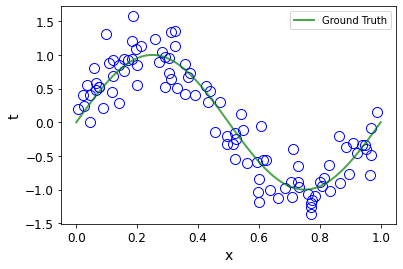

In [3]:
x_ = np.random.rand(100, 1)

# Si quieren elegir a mano los valores de x
# x_ = np.array([0.2, 0.8]).reshape((-1, 1))

t_ = np.sin(2*np.pi*x_) + np.random.randn(len(x_), 1) * 0.3

plot_data_sine(x_, t_)

In [4]:
x_train, x_test = x_[:75], x_[75:]
t_train, t_test = t_[:75], t_[75:]

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [20]:
modelo=Pipeline([('poly',PolynomialFeatures()),('reg',LinearRegression(fit_intercept=False))])
parameters={'poly__degree':np.arange(1,12)}
grilla=GridSearchCV(modelo,parameters,scoring='neg_mean_squared_error')
grilla.fit(x_train,t_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('reg',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=False,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'poly__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])},
             pre_dispatch='2*n_jobs',

In [21]:
grilla.best_params_

{'poly__degree': 3}

In [22]:
grilla.best_estimator_['reg'].coef_

array([[ 1.45777444e-03,  1.07653401e+01, -3.31921003e+01,
         2.25883398e+01]])

Pero existe otro camino... El camino de Bayes. Este lleva a habilidades que muchos consideran poco naturales...

## Prior para $\vec{w}$

Asumamos $\beta$ conocido y consideremos ahora a los $\vec{w}$ como variables aleatorias. Como tal, podemos considerar un prior previo a las mediciones

$$p(\vec{w}|\gamma)$$

donde $\gamma$ son los parametros del prior. Es uno de los **hiperparametros** del modelo.

Dado que la verosimilitud es una normal, podemos utilizar la prior conjugada: [otra normal](https://knowyourmeme.com/photos/1578199-emperor-palpatine-ironic).

$$p(\vec{w}|\gamma)=\mathcal{N}(\vec{w}|0,\gamma^{-1}\mathbf{I}_{(M+1)\mathrm{x}(M+1)})$$

Donde $\gamma$ es un unico numero que controla la precision de los parametros. 
Dado que tenemos $M+1$ parametros (ya que incluimos el sesgo $w_{0}$:

$$p(\vec{w}|\gamma)=\left(\frac{\gamma}{2\pi}\right)^{(M+1)/2} \exp{\left\{-\frac{\gamma}{2}\vec{w}^T\vec{w}\right\}}$$

## Máximo a posteriori (MAP)

Para encontrar la distribución posterior de los parámetros, usamos el teorema de Bayes.

$$
p(\vec{w} | t, \beta, \gamma) = \frac{p(t | \vec{w}, \beta, \gamma)\,p(\vec{w} | \gamma)}{p(t | \beta, \gamma)}\;\;,
$$ 

donde escribí de forma explícita todos los elementos condicionales salvo $x$ y los hiperparámetros $\beta$ y $\gamma$). 

Antes de ir a la posterior, podemos sacar el MAP. Como su nombre lo indica, es encontrar el vector $\vec{w}_{MAP}$ que maximiza la posterior. Dado que incorpora la informacion del prior, es menos propenso al sobreajuste que el $\vec{w}_{ML}$. Dado que el numerador es una constante con respecto a $\vec{w}$, podemos obviarlo para buscar la maximización de la posterior.

Entonces, tenemos

$$p(\vec{w} | t, \beta, \gamma) \propto p(t | \vec{w}, \beta, \gamma)\,p(\vec{w} | \gamma)$$ 

Podemos hacer esto numericamente o aprovechar que utilizamos un prior conjugado que nos permite encontrar soluciones analiticas. Nuevamente, conviene considerar el logaritmo de la posterior

$$\text{Ln }p(\vec{w}|t,\beta,\gamma) = \text{Ln }p(t|\vec{w},\beta,\gamma) + \text{Ln }p(\vec{w}|\gamma) +\text{ cte} $$

$$\text{Ln }p(\vec{w}|t,\beta,\gamma) = -\frac{\beta}{2}\sum_{n=1}^N \left\{t_n - \vec{w}^{T}\vec{\phi}(x_n)\right\}^2 - \frac{\gamma}{2}\vec{w}^{T}\vec{w} +\text{ cte} $$


El ojo avispado puede darse cuenta de que esta funcion a maximizar es la que consideramos cuando vimos regresion INSERTE EL TIPO DE REGRESION AQUI identificando IDENTIFICACION AQUI. 

Maximizando este posterior, tenemos que

$$
\vec{w}_\mathrm{MAP} = \left(\frac{\gamma}{\beta}\mathrm{\mathbf{I}} + \Phi^{T} \cdot\Phi\right)^{-1}\cdot \Phi^{T}\cdot t
$$

y en efecto $\frac{\gamma}{\beta}$ controla el peso relativo entre prior y verosimilitud. Si vamos al limite $\gamma \rightarrow 0$ vemos que $\vec{w}_{MAP}\rightarrow\vec{w}_{ML}$. Esto se explica muy facilmente: en ese limite el prior se vuelve uniforme y no agrega informacion a los datos, por lo que MAP y ML son equivalentes.

Con otras elecciones de prior, podemos llegar a Lasso u otro tipo de regularizaciones (ver ec. 3.56 del [Bishop](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)).

In [18]:
beta = 1/0.3
gamma = 1e-2 / 0.3 # gamma/beta = lambda 
M = 8

poly=PolynomialFeatures(degree=M)

Phi_train=poly.fit_transform(x_train)
Phi_test=poly.transform(x_test)

### Ejercicio:

Resolvamos las ecuaciones normales:

## Distribucion posterior

Ahora si obtengamos el posterior. La ventaja de utilizar priors conjugados es que sabemos la forma de la posterior

$$p(\vec{w}|t,\gamma,\beta)=\mathcal{N}(\vec{w}|\vec{\mu}_{N},\mathbf{S}_{N})$$

Con un poco de analisis podemos ver que para nuestro prior obtenemos que:

$$
\boxed{\begin{array}{lll}
\vec{\mu}_N &=& \beta\;\mathbf{S}_N \cdot \Phi^{T}\cdot t\\
\mathbf{S}^{-1}_N &=& \gamma\;\mathbf{I} + \beta\;\Phi^{T}\cdot\Phi\;\;.
\end{array}}
$$

Noten que si metemos el resultado de $\mathbf{S}_N$ en al ecuación de la media, recuperamos la ecuación de arriba para $\vec{w}_\mathrm{MAP}$. Esto sucede porque, como la normal es simétrica, el valor que maximiza la posterior es también el valor medio de la distribucion.

Si tomamos un prior más general (pero siempre normal):

$$
p(\vec{w} | \vec{\mu}_0, \mathbf{S}_0) = \mathcal{N}(\vec{w} | \vec{\mu}_0, \mathbf{S}_0)\;\;,
$$

donde ahora la matiz de covarianza es general. Entre otras cosas, esto permite acomodar constantes de regularización diferentes para cada parámetro. Además, podemos pensar en una matriz no diagonal, mucho más flexible. 

En este caso el valor medio y matriz de precisión de la posterior es:

$$
\boxed{\begin{array}{lll}
\vec{\mu}_N &=& \mathbf{S}_N\cdot \left(\mathbf{S}^{-1}_0 \cdot \vec{\mu}_0 + \beta\;\Phi^{T}\cdot t\right)\\
\mathbf{S}^{-1}_N &=& \mathbf{S}^{-1}_0 + \beta\;\Phi^{T}\cdot\Phi\;\;.
\end{array}}
$$

Con esto, tenemos una descripción completa de la distribución del vector de parámetros $\vec{w}^{T} = (w_0, \ldots, w_M)$. 

## Ejercicio: Fitteando una recta ruidosa de manera Bayesiana.

Tratemos de fittear los parametros $a_{0}$, $a_{1}$ de una recta $f(x,\vec{a}) = a_0 + a_{1}x$ donde $x$ está en el intervalo $[-1,1)$.

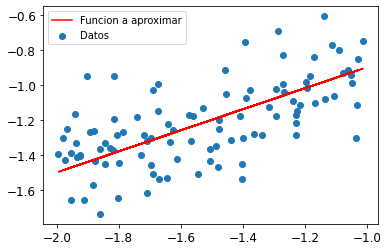

In [6]:
np.random.seed(42)
a0, a1 = -0.3, 0.6
var = 0.2
N = 100
x = -2.0 + np.random.rand(N)
f = a0+a1*x
t = a0+a1*x+var*np.random.randn(N)
plt.scatter(x,t,label='Datos')
plt.plot(x,f,color='red',label='Funcion a aproximar')
plt.legend(loc='upper left')

Como modelo usaremos una regresión lineal de la forma $y(x) = \omega_0 + \omega_1 x$. Escribamos para estos la matriz de diseño.
$$\Phi = \begin{pmatrix}
\phi_0(x_1) & \phi_1(x_1)\\
\phi_0(x_2) & \phi_1(x_2)\\
\vdots & \vdots\\
\phi_0(x_N) & \phi_1(x_N)\\
\end{pmatrix}$$

In [7]:
Phi=np.vstack((x**0.0,x)).T
print(Phi.shape)
print(Phi[0])

(100, 2)
[ 1.         -1.62545988]


Obtengamos el *estimador de máxima verosimilitud* dado por 
$$\begin{pmatrix}
\omega_0^\text{ML}\\
\omega_1^\text{ML}\\
\end{pmatrix} 
= \left(\Phi^T \Phi\right)^{-1}\Phi^T \,\vec{t}
$$
donde recordemos que $\vec{t} = \begin{pmatrix}t_1\\ \vdots \\ t_N\end{pmatrix}$ es el vector de los valores *target* medidos.

Si ahora utilizamos un prior gaussiano de la forma $p(\vec{\omega}) = \mathcal{N} (\vec{0},\gamma^{-1}{\bf 1})$ (es decir que $p(\vec{\omega}) = p(\omega_0) \times p(\omega_1)$ con cada $p(\omega_i) = \mathcal{N} (\mu=0,\sigma = \gamma)$ ) podemos actualizar iterativamente nuestra distribucion. Que quiere decir esto?

Para $n=1,...,N$:

$$p_{n}(\vec{w})=\frac{p(t_{n}|x_{n},\vec{w},\gamma, \beta)p_{n-1}(\vec{w}|\gamma,\beta,t_{1,...,n-1},x_{1,...,n-1})}{p(t_{n}|x_{n},\vec{w},\gamma, \beta,t_{1,...,n-1},x_{1,...,n-1})}$$

Con $p_{0}(\vec{w})=\mathcal{N} (\vec{0},\gamma^{-1}{\bf 1})$. Es decir, el posterior para el dato $n-1$ se transforma en el prior para el dato $n$.

Calculemos la verosimilitud y el posterior al usar solo 1 punto, 2 puntos, 3 puntos y todo el conjunto de 100 puntos. Para cada uno de estos casos grafiquemos:

*   El prior en esa iteracion en el espacio ($w_0$,$w_1$)
*   La recta en el espacio (x,t) definida por los ($w_0$,$w_1$) que maximizan el prior junto con la verdadera recta definida por ($a_0$,$a_1$).
*   La verosimilitud en esa iteracion en el espacio ($w_0$,$w_1$)
*   El posterior en esa iteracion en el espacio ($w_0$,$w_1$)


Utilicemos un metodo numerico y comparemos con la formula analitica del posterior.
$$
\vec{\mu}_N = \beta {\bf S}_N \Phi^T \vec{t}\\
{\bf S}_N^{-1} = \gamma {\bf 1} + \beta \Phi^T \Phi
$$
donde $\beta$ es el parámetro de precisión del ruido gaussiano, que en nuestro caso es $\beta = (1/\sigma)^2 = (1/0.2)^2 = 25$. Para seleccionar la cantidad de puntos a considerar, podemos usar slicing en $\vec{t}$ ( ``t[:N_puntos]``) y en $\Phi$ (``Phi[:N_puntos,:]``).

In [ ]:
from scipy.stats import norm, multivariate_normal
gamma=2.0
# valores posibles
w0_values=np.linspace(-1.0,1.0,50)
w1_values=np.linspace(-1.0,1.0,100)
#para plottear
W0, W1 = np.meshgrid(w0_values,w1_values)
pos=np.dstack((W0,W1))
#definimos las listas vacias
prior=[]
verosimilitud=[]
posterior=[]

# para el dato 0:
prior.append(multivariate_normal(mean=[0.0,0.0],cov=gamma*np.eye(2)).pdf(pos))

for i in range(len(x)):#loopeo sobre datos
  verosimilitud.append()#formula de la verosimilitud para el dato i
  evidencia =  #evidencia numerica para el dato 
  posterior.append()#posterior normalizado para el dato 

# sampleo puntos de (w0,w1) maximos para prior. Utilicen np.where(a==np.max(a)) para encontrar los indices donde esta el maximo. Si hay varios maximos, quedense con el primero.

  sampleo_prior=[,]

# grafico

  if(i==0 or i==1 or i==2 or i==len(x)-1):
    fig, axes = plt.subplots(1,4, figsize=(20,3))
    axes[0].contourf(W0,W1,prior[-1])
    axes[0].scatter(a0,a1,marker='x',color='black')
    axes[0].scatter(sampleo_prior[0],sampleo_prior[1],marker='+',color='red')
    axes[0].set_title('Prior en ($w_0$,$w_1$)')
    axes[1].scatter(x[:i+1],t[:i+1],color='black')
    axes[1].plot(x,sampleo_prior[0]+sampleo_prior[1]*x,color='red')
    axes[1].plot(x,a0+a1*x,color='green')
    axes[1].set_title('Sampleo en (x,t)')
    axes[2].contourf(W0,W1,verosimilitud[-1])
    axes[2].scatter(a0,a1,marker='x',color='black')
    axes[2].set_title('Verosimilitud en ($w_0$,$w_1$)')
    axes[3].contourf(W0,W1,posterior[-1])
    axes[3].scatter(a0,a1,marker='x',color='black')
    axes[3].set_title('Posterior en ($w_0$,$w_1$)')

    fig.show()

# actualizo el prior
  prior.append(posterior[-1])

## Posterior predictiva

Repasemos un poco lo que vimos en su momento de posterior predictiva y apliquemoslo aca. Volviendo a los datos simples

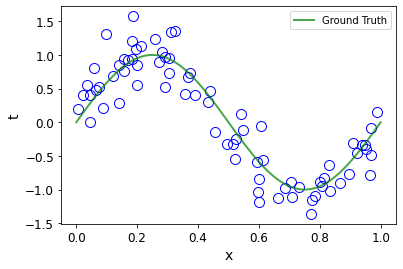

In [14]:
x_train, x_test = x_[:75], x_[75:]
t_train, t_test = t_[:75], t_[75:]
plot_data_sine(x_train,t_train)

Obtengamos los parametros de la posterior

In [153]:
beta = 1/0.3
gamma = 1e-2 / 0.3 # gamma/beta = lambda 
mu0=0.0
M = 4

poly=PolynomialFeatures(degree=M)

Phi_train=poly.fit_transform(x_train)
Phi_test=poly.transform(x_test)

$$
\boxed{\begin{array}{lll}
\vec{\mu}_N &=& \mathbf{S}_N\cdot \left(\mathbf{S}^{-1}_0 \cdot \vec{\mu}_0 + \beta\;\Phi^{T}\cdot t\right)\\
\mathbf{1} &=& \left(\mathbf{S}^{-1}_0 + \beta\;\Phi^{T}\cdot\Phi\right)\cdot \mathbf{S}_{N}\;\;.
\end{array}}
$$

In [154]:
SN=np.linalg.solve(gamma*np.eye(M+1)+beta*np.dot(Phi_train.T,Phi_train),np.eye(M+1))
muN=beta*np.dot(SN,np.dot(Phi_train.T,t_train))

In [ ]:
print(np.linalg.inv(SN)/(len(x_train)*beta),np.mean(x_train),np.mean(x_train**2))## verficacion para M = 1

In [156]:
print(muN.shape,SN.shape)

(5, 1) (5, 5)


Teniendo la distribucion $p(\vec{w}|\vec{\mu}_{N},\mathbf{S}_{N})$, podemos ahora tratar de hacer predicciones para una nueva medicion:

$$p(t_{N+1}|x_{N+1},x_{1,...,N},t_{1,...,N},\gamma,\beta)$$

Como hicimos en el caso de la distribucion Cauchy, podemos escribir esto marginalizando sobre los parametros posibles $\vec{w}$.

$$p(t_{N+1}|x_{N+1},x_{1,...,N},t_{1,...,N},\gamma,\beta)=\int p(t_{N+1}|x_{N+1},\vec{w},\beta)p(\vec{w}|\vec{\mu}_{N},\mathbf{S}_{N})d^{M+1}w$$

Esta integral es, a simple vista, un poco aterradora. Veamos que podemos hacer al respecto


### Predicciones semi-bayesianas

Podemos, antes que nada, aproximar $\vec{w}$ por el valor de Maximo A Posteriori

$$p(t_{N+1}|x_{N+1},x_{1,...,N},t_{1,...,N},\gamma,\beta)\approx \mathcal{N}(t_{N+1}|y(x_{N+1},\vec{w}_{MAP}),\beta)$$

Debido a que la posterior es una Gaussiana, $\vec{w}_{MAP}=\vec{\mu}_{N}$


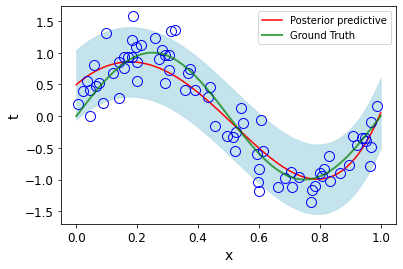

In [157]:
Phi_xx=poly.transform(xx)

tt=np.dot(Phi_xx,muN)

plt.plot(xx,tt,c='red',label='Posterior predictive')
plt.fill_between(xx.flatten(), tt.flatten() + np.sqrt(1/beta), tt.flatten() - np.sqrt(1/beta), color='LightBlue', alpha=0.7)
plot_data_sine(x_train,t_train)

### Funcion predictiva posterior

Para hacer la integral que ya mencionamos, podriamos ir directo al enfoque numerico. Tal como hicimos en algunos ejercicios de la guia, podemos recurrir al Importance Sampling. Alli, sampleamos puntos utilizando la posterior

In [158]:
Nsample=1000
w_sampled=multivariate_normal(mean=muN[:,0],cov=SN).rvs(Nsample)

Y utilizamos esos puntos sampleados para calcular

$$p(t_{N+1}|x_{N+1},x_{1,...,N},t_{1,...,N},\gamma,\beta)\approx \frac{1}{N_{\text{samples}}}\sum_{j=1}^{N_{\text{samples}}}\mathcal{N}(t_{N+1}|y(x_{N+1},\vec{w}_{j}),\beta)$$

Entonces, podemos obtener el valor promedio de $t_{N+1}$ como

$$\mathbf{E}[t_{N+1}]\approx \frac{1}{N_{\text{samples}}}\sum_{j=1}^{N_{\text{samples}}}\vec{w}_{j}^{T}\cdot \vec{\phi}(x_{N+1})=\frac{1}{N_{\text{samples}}}\sum_{j=1}^{N_{\text{samples}}}\mu_{j}$$

y la varianza viene dada por

$$\text{Var}[t_{N+1}]\approx \frac{1}{\beta}+\frac{1}{N_{\text{samples}}}(\sum_{j}\mu^{2}_{j}-\frac{1}{N_{\text{samples}}}(\sum_{l}\mu_{l})^{2})$$




In [159]:
mus=np.dot(w_sampled,Phi_xx.T)
print(mus.shape)
tt=np.mean(mus,axis=0)
print(tt.shape)

(1000, 100)
(100,)


In [160]:
sum_mu=np.sum(mus,axis=0)
sum_mu_sqr=np.sum(np.asarray([mus[:,i]*mus[:,i] for i in range(mus.shape[1])]).T,axis=0)
yerror=np.sqrt(1.0/beta+(1.0/Nsample)*(sum_mu_sqr-(1.0/Nsample)*sum_mu))

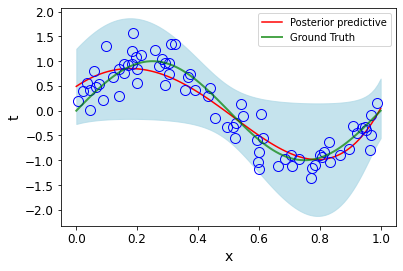

In [161]:
plt.plot(xx,tt,c='red',label='Posterior predictive')
plt.fill_between(xx.flatten(), tt.flatten() + yerror.flatten(), tt.flatten() - yerror.flatten(), color='LightBlue', alpha=0.7)
plot_data_sine(x_train,t_train)

Esto es util, si, pero no estamos aprovechando la belleza de usar priors conjugados. Todavia podemos resolver cosas analiticamente!

La posterior predictiva va a ser

la posterior predictiva:

$$
p(t_{N+1} | x_{N+1}, t_{1,...,N}, x_{1,...,N}, \gamma, \beta) = \mathcal{N}(t_{N+1} | \vec{\mu}_N^{T} \vec{\phi}(x_{N+1}), \sigma_N^2)\;\;,
$$

donde la varianza es
$$
\sigma_N^2 = \frac{1}{\beta} + \vec{\phi}(x_{N+1})^{T} \mathbf{S}_N \vec{\phi}(x_{N+1})\;\;,
$$
que consiste en una contribución debida a la incertidumbre en los parámetros, y otra que viene de la incerteza de los datos.

In [162]:
mupred=np.dot(muN.T,Phi_xx.T).T
aux=np.asarray(list(map(lambda i: np.dot(Phi_xx[i,:],np.dot(SN,Phi_xx[i,:])),range(Phi_xx.shape[0]))))
sigmapred=np.sqrt(1.0/beta+aux)

In [163]:
sigmapred.shape

(100,)

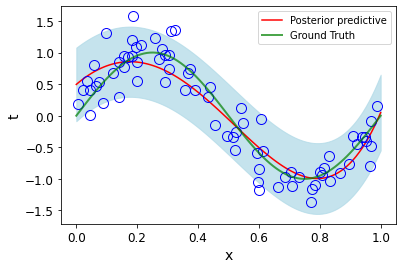

In [164]:
plt.plot(xx,mupred,c='red',label='Posterior predictive')
plt.fill_between(xx.flatten(), mupred.flatten() + sigmapred.flatten(), mupred.flatten() - sigmapred.flatten(), color='LightBlue', alpha=0.7)
plot_data_sine(x_train,t_train)

### Ejercicio

Repitamos todo esto eligiendo unicamente 2 puntos al azar para entrenar el modelo. Que pasa?